# 推荐系统实战-3

## 隐语义模型实战

使用 [Text8](http://mattmahoney.net/dc/textdata) 数据集训练word2vec

1. 安装依赖库

In [1]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile

from matplotlib import pylab
from sklearn.manifold import TSNE
print('check: libs well prepared')

check: libs well prepared


2. 下载数据并解压

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    # 判断文件是否存在
    if not os.path.exists(filename):
        # 下载
        print('download...')
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
        
    # 校验大小
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print('exception %s' % statinfo.st_size)
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


3. 编码并替换低频次

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    # 每个词出现的次数
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    # 单词到数字的映射
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    # 数字到单词的映射
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# 映射之后的训练数据
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


4. 生成skip-gram训练数据

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # context word
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        # 循环使用
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # 目标，当前词
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[target]  # 参考词
            labels[i * num_skips + j, 0] = buffer[skip_window]  # 预测词
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

# data是给定语料，用buffer作为大小span（2*skip_window+1）的窗口扫描data去抽样
# target是skip-gram算法的中间词，通过循环取出num_skips个左右skip_window内的欲预测周围词
# 被预测词存到batch中，欲预测词存到labels中
print('data:', [reverse_dictionary[di] for di in data[:8]])
data_index = 0
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
print('     batch:', [reverse_dictionary[bi] for bi in batch])
print('     labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
     batch: ['term', 'originated', 'of', 'term', 'a', 'abuse', 'a', 'term']
     labels: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']


5. 定义网路结构

In [6]:
batch_size = 128  # batch size
embedding_size = 128  # word embedding size
skip_window = 1  # context skip window(one side)
num_skips = 2  # num of predicted word in context
valid_size = 16  # 采样数量
valid_window = 100  # 查看训练效果的窗口
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()\

with graph.as_default(), tf.device('/cpu:0'):
    # 输入数据
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 定义变量
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # 本次训练数据对应的embedding
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)  # 128x128
    # neg softmax batch loss
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases,
                                                     inputs=embed, labels=train_labels,
                                                     num_sampled=num_sampled, num_classes=vocabulary_size))
    # 优化loss，更新参数
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    # 归一化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))  # 50000x1
    normalized_embeddings = embeddings / norm  # 50000x128
    # 用已有embedding计算valid的相似性
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # 16x128
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))  # 16x50000

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


6. 运行训练流程

In [7]:
num_steps = 100000

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    average_loss = 0
    
    for step in range(num_steps + 1):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        # 每2000次打印loss
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # 每10000次打印valid效果
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):  # 16
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 5  # 取出相似度最高的top 5个词
                nearest = (-sim[i, :]).argsort()[1:top_k+1]  # argsort()[0]是valid_word词本身
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,'  % (log, close_word)
                print(log)
        final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 8.153049
Nearest to by: familias, boardgamegeek, neo, samaritan, anglo,
Nearest to eight: cypriot, obstacles, neely, eixample, mears,
Nearest to its: nucleotide, meanings, koo, failures, overdosing,
Nearest to five: apathy, hissarlik, hickory, brian, attractive,
Nearest to while: piloting, amt, harmonics, cryptanalysis, maison,
Nearest to years: guarantee, harassed, ivo, troughs, nexgen,
Nearest to when: pooh, cytoplasmic, neologisms, steps, kant,
Nearest to often: franz, owner, avec, adviser, gm,
Nearest to s: habitable, alarmed, occurring, bamar, diurnal,
Nearest to new: soot, legionnaire, pessimistic, profiling, rennet,
Nearest to be: weighed, easing, gordian, grattan, machined,
Nearest to more: panzer, qadhafi, sravaka, fugal, lille,
Nearest to th: zarqawi, hostility, glorify, decency, allege,
Nearest to other: claiming, salinas, majesty, immoral, jordanes,
Nearest to only: ancestry, knowing, quarters, internationals, capita,
Nearest to after: laozi, cfaf, s

Average loss at step 72000: 4.919473
Average loss at step 74000: 4.877082
Average loss at step 76000: 4.965496
Average loss at step 78000: 4.933943
Average loss at step 80000: 5.071897
Nearest to by: and, as, on, from, of,
Nearest to eight: three, four, five, six, nine,
Nearest to its: the, a, some, szko, goldwyn,
Nearest to five: four, eight, zero, three, nine,
Nearest to while: is, from, in, were, favre,
Nearest to years: nascar, naxos, fao, months, tique,
Nearest to when: was, has, during, with, in,
Nearest to often: mainly, dueling, techniques, not, lollards,
Nearest to s: and, UNK, was, m, of,
Nearest to new: methuen, latest, bresson, furnace, discus,
Nearest to be: refer, onlookers, according, kamov, akin,
Nearest to more: have, shaivism, snail, delaney, very,
Nearest to th: constantius, quechua, buttocks, cebit, proverbial,
Nearest to other: generalisations, breakdancing, eolian, more, livejournal,
Nearest to only: cti, croatia, pamphlets, sheedy, tariq,
Nearest to after: during

7. 可视化

In [8]:
num_points = 400  # 可视化400个点
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

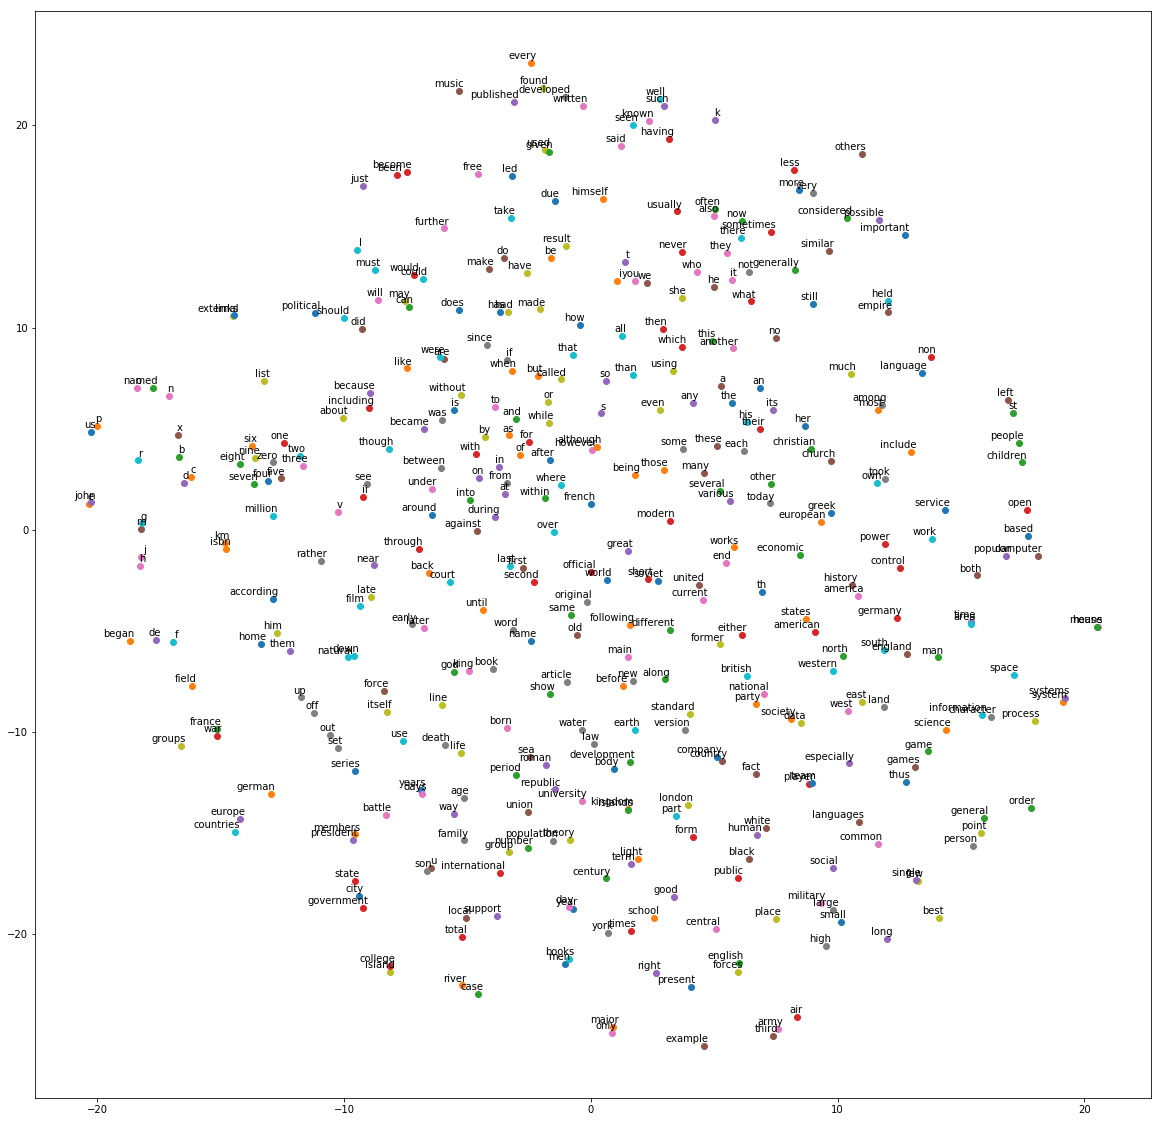

In [9]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(20, 20))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()
words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)